# Warning
This notebook is under development- please use to evaluate entropy notebook and suggest desired changes only.

# Experiments on amplitude

## Import libraries

In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import collections
from collections import namedtuple
import builtins
import math
import mne
# import our library
from sklearn.decomposition import FastICA
from picard import picard
#

# import resurfemg.config as config



C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


In [2]:
# get new changes in our library i.e. the tmsisdk
import sys
sys.path.insert(0, '../resurfemg')

from tmsisdk_lite import Poly5Reader
import helper_functions as hf

In [3]:
# configure our data
from resurfemg.config import Config
config = Config()
root_emg_directory = config.get_directory('root_emg_directory')

# Set a collection place for experiments

In [4]:
# do not rerun this cell
big_data_list = []

Below change the path to the root directory where you are keeping your EMGs and ventilator "Draeger" files

# Reruns should be done from this cell as the start

In [5]:
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_draeger_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
draeger_files = []

for file in emg_and_draeger_files:
    if 'Draeger' in file:
        draeger_files.append(file)
    else:
        emg_files.append(file)

Now you can pick a file from the list, which have been numbered.

In [6]:
list_of_numbers_strung = []
for i in range(len(emg_files)):
    list_of_numbers_strung.append(str(i))


btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value='0',
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '1…

# Caution! 
If you folder is set up in any way different then the picked file numbers will not neccesarily correspond to the same file. Always check the print out for the file you have chosen in the cell below

In [7]:
number_chosen = int(btn.value)
file_chosen = emg_files[number_chosen] 
print("The file you chose is:",file_chosen)

The file you chose is: C:/Projects/ReSurfEMG/not_pushed/topspin_data_anonymized\M001\001\EMG_recording.Poly5


In [8]:
data_emg = Poly5Reader(file_chosen)
data_samples= data_emg.samples
emg_sample_rate = data_emg.sample_rate
converted_to_seconds =  []
converted_to_samples = []
for i in range(len(data_samples[0])):
    converted_to_seconds.append(i/emg_sample_rate)
    converted_to_samples.append(i)

Reading file  C:/Projects/ReSurfEMG/not_pushed/topspin_data_anonymized\M001\001\EMG_recording.Poly5
	 Number of samples:  172576 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.


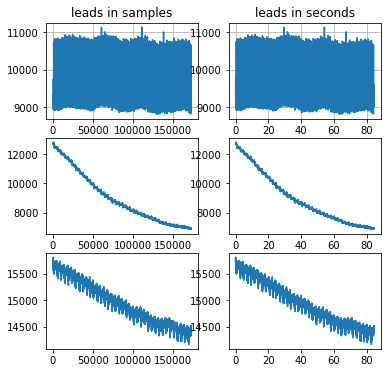

In [9]:
%matplotlib inline
# set up plotn
x = data_samples
fig, axis = plt.subplots(nrows = 3, ncols = 2, figsize=(6, 6))
#ax.set_ylim([-4, 4])
axis[0,0].grid(True)
axis[0,0].plot(x[0])
axis[0,0].set(title='leads in samples')
axis[1,0].plot(x[1])
axis[2,0].plot(x[2])
axis[0,1].set(title='leads in seconds')
axis[0,1].grid(True)
axis[0,1].plot(converted_to_seconds,x[0])
axis[1,1].plot(converted_to_seconds,x[1])
axis[2,1].plot(converted_to_seconds,x[2])

That is the whole unfiltered EMG, but you probably want to examine a part. You will also want to examine something filtered down to only the EMG components. Therefore we will filter off only the EMG components with an ICA in addtion to the filter we will play with.

Now you can filter down to which part you want to see. 

Do you want to cut and see the file in samples or seconds?

In [10]:
y_axis = widgets.Dropdown(
    options=["Samples","Seconds"],
    value='Samples',
    description="Select View Option",
    disabled=False,
)
display(y_axis)


Dropdown(description='Select View Option', options=('Samples', 'Seconds'), value='Samples')

In [11]:
time_view= y_axis.value
time_view

'Samples'

Now you will pick the start and end of your sample.We are going to clip the end of the sample in processing, so you can not pick any values and get a good graph. We preset the values towards the max graphable with ease, but they can be overwritten.  In the future we will have an updating graph here. 

In [12]:
if time_view == 'Samples':
    int_slider1 = widgets.IntSlider(
        min=0, max=int(len(x[0])*0.89), step=1,
        description=' samples start'
    )
    int_slider2 = widgets.IntSlider(
        value=len(x[0]),
        min=0, max=int(len(x[0])*0.89), step=1,
        description='samples end cutoff'
    )
else:
    int_slider1 = widgets.IntSlider(
        #value=0.1,
        min=0, max= int(converted_to_seconds[-1])*0.89, step=1,
        description='seconds start'
    )
    int_slider2 = widgets.IntSlider(
        #value=converted_to_seconds[-1],
        min=0, max=int(converted_to_seconds[-1])*0.89, step= 1,
        description='seconds end cutoff'
    )
    
widgets.VBox(
    [

        int_slider1,
        int_slider2,

    ]
)



You can overwrite the values by hand in the next cell, if scrolling is not precise enough...but rewriting to take an absolute end is unadvisable.

In [13]:
# # # # Here we can overwrite the values by hand, again you must pick values a bit inside
int_slider1.value = 5000
int_slider2.value = 70000

For now we will graph your choice in the next active cell

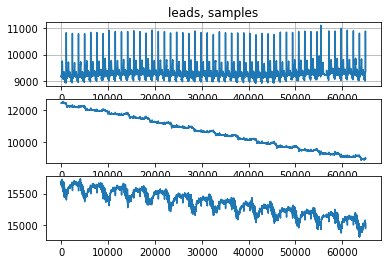

In [14]:
start = int_slider1.value
end= int_slider2.value
if time_view == 'Samples':
    # nox examine at a certain scale- from point a to b as samples
    x = data_samples
    fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
    ax_1.grid(True)
    ax_1.plot(x[0][int(start):int(end)])
    ax_1.set(title='leads, samples')
    ax_2.plot(x[1][int(start):int(end)])
    ax_3.plot(x[2][int(start):int(end)])
    
if time_view == 'Seconds':
    # nox examine at a certain scale- from point a to b as samples
    x_for_secs = data_samples

    y = converted_to_seconds
    fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
    ax_1.grid(True)
    ax_1.plot(y[int(start*emg_sample_rate):int(end*emg_sample_rate)],x[0][int(start*emg_sample_rate):int(end*emg_sample_rate)])
    ax_1.set(title='leads, seconds')
    ax_2.plot(y[int(start*emg_sample_rate):int(end*emg_sample_rate)],x[1][int(start*emg_sample_rate):int(end*emg_sample_rate)])
    ax_3.plot(y[int(start*emg_sample_rate):int(end*emg_sample_rate)],x[2][int(start*emg_sample_rate):int(end*emg_sample_rate)])
    

In [15]:
def working_pipeline_exp(our_chosen_file):
  
    cut_file_data = bad_end_cutter(
        our_chosen_file,
        percent_to_cut=3,
        tolerance_percent=5,
    )
    bd_filtered_file_data = emg_bandpass_butter_sample(
        cut_file_data,
        5,
        450,
        2048,
        output='sos',
    )
    # end-cutting again to get rid of filtering artifacts
    re_cut_file_data = bad_end_cutter_for_samples(
        bd_filtered_file_data,
        percent_to_cut=3,
        tolerance_percent=5,
    )
    # do ICA
    components = compute_ICA_two_comp(re_cut_file_data)
    #  pick components with more peaj
    emg = pick_more_peaks_array(components)
    # now process it in final steps
    abs_values = abs(emg)
    final_envelope_d = emg_highpass_butter(abs_values, 150, 2048)
    final_envelope_a = naive_rolling_rms(final_envelope_d, 300)

    return 

In [16]:

emg = hf.emg_bandpass_butter_sample(
        data_samples,
        5,
        450,
        2048,
        output='sos',
    )
print(np.max(emg[0]), np.min(emg[0]))

1486.8475113550787 -460.73702045264105


# Her we print out max and min after a bandpass_butter_sample filter

In [17]:
print(np.max(emg[0][0:150000]),np.min(emg[0][0:150000]))
print(np.max(emg[1][0:150000]),np.min(emg[1][0:150000]))
print(np.max(emg[2][0:150000]),np.min(emg[2][0:150000]))

1486.8475113550787 -460.73702045264105
112.49964354832512 -73.78830787442581
144.69583466570043 -146.96137357220795


## Let's get precise about the amplitudes we think are going into the ICA now:

In [18]:
print("Lead 0 has", np.max(emg[0][0:150000])-np.min(emg[0][0:150000]), "variance in amplitude")
print("Lead 1 has", np.max(emg[1][0:150000])-np.min(emg[1][0:150000]), "variance in amplitude")
print("Lead 2 has", np.max(emg[2][0:150000])-np.min(emg[2][0:150000]), "variance in amplitude")

Lead 0 has 1947.5845318077197 variance in amplitude
Lead 1 has 186.28795142275095 variance in amplitude
Lead 2 has 291.6572082379084 variance in amplitude


## If lead 0 was our heart lead we are cooking well. We would expect a difference in ECG and EMG like amplitude on a significant orger of magnitude. Now let's graph it

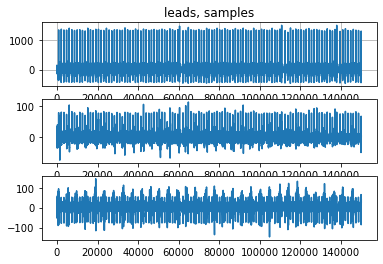

In [19]:
# graph part of it to examine
x = emg
fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
ax_1.grid(True)
ax_1.plot(x[0][0:150000])
ax_1.set(title='leads, samples')
ax_2.plot(x[1][0:150000])
ax_3.plot(x[2][0:150000])
    

In [20]:
# here we graph out components after a cut

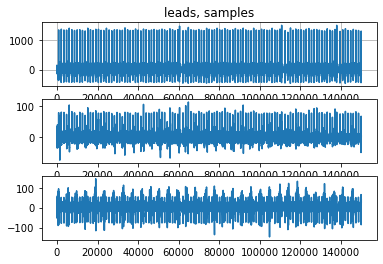

In [21]:
re_cut_file_data = hf.bad_end_cutter_for_samples(
        emg,
        percent_to_cut=3,
        tolerance_percent=5,
    )
x = re_cut_file_data
fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
ax_1.grid(True)
ax_1.plot(x[0][0:150000])
ax_1.set(title='leads, samples')
ax_2.plot(x[1][0:150000])
ax_3.plot(x[2][0:150000])

In [22]:
re_cut_file_data.shape

(3, 167398)

In [23]:
# Now we do the type of ICA we used versus one with arbitrary variance
def new_compute_ICA_two_comp(emg_samples, whiten):
    """A function that performs an independant component analysis
    (ICA) meant for EMG data that includes stacked three arrays.

    :param emg_samples: Original signal array with three layers
    :type emg_samples: ~numpy.ndarray

    :returns: Two arrays of independent components (ECG-like and EMG)
    :rtype: ~numpy.ndarray
    """
    X = np.c_[emg_samples[0], emg_samples[2]]
    if whiten =='arbitrary-variance':
        ica = FastICA(n_components=2,whiten='arbitrary-variance')
    else:
        ica = FastICA(n_components=2, whiten='unit-variance')
    S = ica.fit_transform(X)
    component_0 = S.T[0]
    component_1 = S.T[1]
    return component_0, component_1



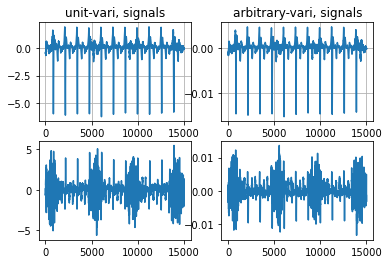

In [24]:
components_scaled = new_compute_ICA_two_comp(re_cut_file_data, whiten='unit-variance')
components_arbitrary =  new_compute_ICA_two_comp(re_cut_file_data, whiten='arbitrary-variance')
x1 = components_scaled
x2 = components_arbitrary
fig, axis = plt.subplots(nrows = 2, ncols= 2, figsize=(6, 4))
axis[0,0].grid(True)
axis[0,0].plot(x1[0][0:15000])
axis[0,0].set(title='unit-vari, signals')
axis[1,0].plot(x1[1][0:15000])
axis[0,1].grid(True)
axis[0,1].plot(x2[0][0:15000])
axis[0,1].set(title='arbitrary-vari, signals')
axis[1,1].plot(x2[1][0:15000])



Note the default will change to unit-variance in ski-kit learn later versions, we willl readjust our  ICA calls to whiten with unit-variance- but still investiage. Let's watch the default not


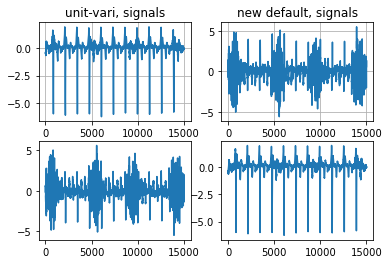

In [25]:
ecomponents_scaled = new_compute_ICA_two_comp(re_cut_file_data, whiten='unit-variance')
ecomponents_default =  hf.compute_ICA_two_comp(re_cut_file_data)
ex1 = ecomponents_scaled
ex2 = ecomponents_default
fig, axis = plt.subplots(nrows = 2, ncols= 2, figsize=(6, 4))
axis[0,0].grid(True)
axis[0,0].plot(ex1[0][0:15000])
axis[0,0].set(title='unit-vari, signals')
axis[1,0].plot(ex1[1][0:15000])
axis[0,1].grid(True)
axis[0,1].plot(ex2[0][0:15000])
axis[0,1].set(title='new default, signals')
axis[1,1].plot(ex2[1][0:15000])


From the sci-kitlearn documentation: "if 'unit-variance', the whitening matrix is rescaled to ensure that
          each recovered source has unit variance"
          
Whatever the case in both algorithm it made heart and emg signals of close to the same variance- wrong.

In [26]:
## Let's look at the amplitude differences directly
print("ICA components unit-variance 0 has", np.max(x1[0][0:150000])-np.min(x1[0][0:150000]), "variance in amplitude")
print("ICA components unit-variance 1 has", np.max(x1[1][0:150000])-np.min(x1[1][0:150000]), "variance in amplitude")
print("ICA components arbitrary-variance 0 has", np.max(x2[0][0:150000])-np.min(x2[0][0:150000]), "variance in amplitude")
print("ICA components arbitrary-variance 1 has", np.max(x2[1][0:150000])-np.min(x2[1][0:150000]), "variance in amplitude")


ICA components unit-variance 0 has 8.755226696486504 variance in amplitude
ICA components unit-variance 1 has 15.316332709880509 variance in amplitude
ICA components arbitrary-variance 0 has 0.0213898050816085 variance in amplitude
ICA components arbitrary-variance 1 has 0.03742436226444748 variance in amplitude


## Now a side question, we still see the ehart signal in there a bit
Would it go diofferently with deflation?
What about running it twice?

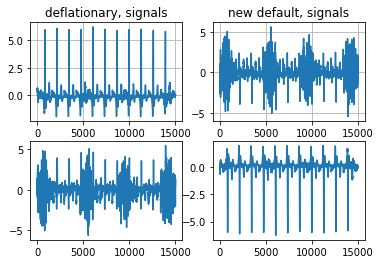

In [30]:
def deflationary_compute_ICA_two_comp(emg_samples, whiten, algorithm= 'deflation'):
    """A function that performs an independant component analysis
    (ICA) meant for EMG data that includes stacked three arrays.

    :param emg_samples: Original signal array with three layers
    :type emg_samples: ~numpy.ndarray

    :returns: Two arrays of independent components (ECG-like and EMG)
    :rtype: ~numpy.ndarray
    """
    X = np.c_[emg_samples[0], emg_samples[2]]
    if whiten =='arbitrary-variance':
        ica = FastICA(n_components=2,whiten='arbitrary-variance')
    else:
        ica = FastICA(n_components=2, whiten='unit-variance')
    S = ica.fit_transform(X)
    component_0 = S.T[0]
    component_1 = S.T[1]
    return component_0, component_1
decomponents_scaled = deflationary_compute_ICA_two_comp(re_cut_file_data, whiten='unit-variance')
ecomponents_default =  
ex1 = decomponents_scaled
ex2 = ecomponents_default
fig, axis = plt.subplots(nrows = 2, ncols= 2, figsize=(6, 4))
axis[0,0].grid(True)
axis[0,0].plot(ex1[0][0:15000])
axis[0,0].set(title='deflationary, signals')
axis[1,0].plot(ex1[1][0:15000])
axis[0,1].grid(True)
axis[0,1].plot(ex2[0][0:15000])
axis[0,1].set(title='new default, signals')
axis[1,1].plot(ex2[1][0:15000])


(array([-0.45042885, -0.41854806, -0.38181159, ...,  0.38001359,
        0.37400232,  0.36397232]), array([ 0.4604825 ,  0.07081284, -0.17211173, ..., -0.03676085,
       -0.05720355, -0.10509049]))


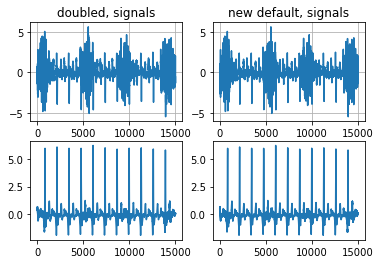

In [39]:
def double_compute_ICA_two_comp(emg_samples):
    """A function that performs an independant component analysis
    (ICA) meant for EMG data that includes stacked three arrays.

    :param emg_samples: Original signal array with three layers
    :type emg_samples: ~numpy.ndarray

    :returns: Two arrays of independent components (ECG-like and EMG)
    :rtype: ~numpy.ndarray
    """
    first = hf.compute_ICA_two_comp(emg_samples)
    print(first)
    c0 = first[0]
    c1 = first[1]
    low_border_c0 = (c0.max() - c0.mean())/4
    peaks0, _0 = find_peaks(c0, height=low_border_c0, distance=10)
    antipeaks0, anti_0 = find_peaks(
        (c0*(-1)),
        height=-low_border_c0,
        distance=10)
    low_border_c1 = (c1.max() - c1.mean())/4
    peaks1, _1 = find_peaks(c1, height=low_border_c1, distance=10)
    antipeaks1, anti_1 = find_peaks(
        (c1*(-1)),
        height=-low_border_c1,
        distance=10,
    )

    sum_peaks_0 = len(peaks0) + len(antipeaks0)
    sum_peaks_1 = len(peaks1) + len(antipeaks1)

    if sum_peaks_0 > sum_peaks_1:
        emg_component = first[0]
        heart_component = first[1]
    elif sum_peaks_1 > sum_peaks_0:
        emg_component = first[1]
        heart_component = first[0]
    
    #second= hf.compute_ICA_two_comp((emg_component, heart_component))
    X = np.c_[emg_component, heart_component]
    ica = FastICA(n_components=2, whiten='unit-variance')
    S = ica.fit_transform(X)
    component_0 = S.T[0]
    component_1 = S.T[1]
    return component_0, component_1


dubcomponents_scaled = double_compute_ICA_two_comp(re_cut_file_data)
ecomponents_default =  hf.compute_ICA_two_comp(re_cut_file_data)
ex1 = dubcomponents_scaled
ex2 = ecomponents_default
fig, axis = plt.subplots(nrows = 2, ncols= 2, figsize=(6, 4))
axis[0,0].grid(True)
axis[0,0].plot(ex1[0][0:15000])
axis[0,0].set(title='doubled, signals')
axis[1,0].plot(ex1[1][0:15000])
axis[0,1].grid(True)
axis[0,1].plot(ex2[0][0:15000])
axis[0,1].set(title='new default, signals')
axis[1,1].plot(ex2[1][0:15000])

# WE can see we lost orders of magnitude in our amplitude when we use the ski-kit learn algorith. Let's try a different ICA

In [27]:
parralell_cut = np.vstack([re_cut_file_data[0],re_cut_file_data[2]])
# np.vstack([re_cut_file_data,re_cut_file_data])
parralell_cut.shape

(2, 167398)

In [28]:
K0, W0, Q = picard(parralell_cut)
K1, W1, Y = picard(parralell_cut, ortho=False, random_state=0)
K2, W2, Z = picard(parralell_cut, ortho=True, random_state=0)
# Picard outputs the whitening matrix, K, 
# the estimated unmixing matrix, W, and the estimated sources Y. It means that Y = WKX

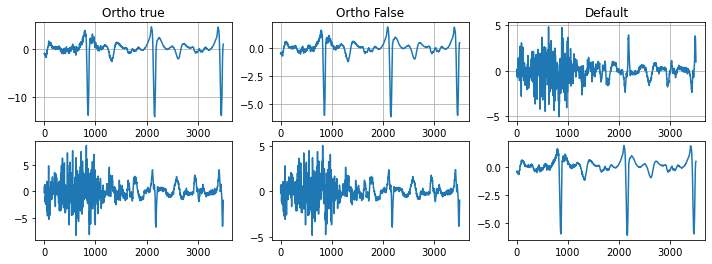

In [29]:
fig, axis = plt.subplots(nrows = 2,ncols=3, figsize=(12, 4))
axis[0,0].grid(True)
axis[0,0].plot(Y[0][0:3500])
axis[0,0].set(title='Ortho true')
axis[1,0].plot(Y[1][0:3500])
axis[0,1].grid(True)
axis[0,1].plot(Z[0][0:3500])
axis[0,1].set(title='Ortho False')
axis[1,1].plot(Z[1][0:3500])
axis[0,2].grid(True)
axis[0,2].plot(Q[0][0:3500])
axis[0,2].set(title='Default')
axis[1,2].plot(Q[1][0:3500])

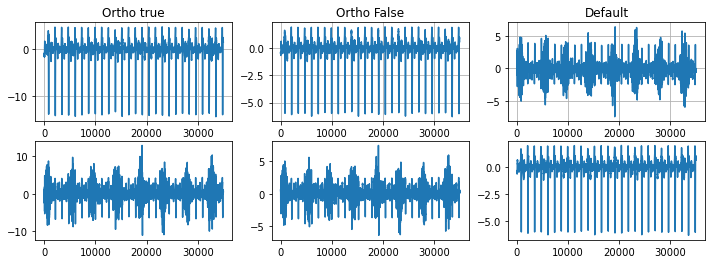

In [30]:
fig, axis = plt.subplots(nrows = 2,ncols=3, figsize=(12, 4))
axis[0,0].grid(True)
axis[0,0].plot(Y[0][0:35000])
axis[0,0].set(title='Ortho true')
axis[1,0].plot(Y[1][0:35000])
axis[0,1].grid(True)
axis[0,1].plot(Z[0][0:35000])
axis[0,1].set(title='Ortho False')
axis[1,1].plot(Z[1][0:35000])
axis[0,2].grid(True)
axis[0,2].plot(Q[0][0:35000])
axis[0,2].set(title='Default')
axis[1,2].plot(Q[1][0:35000])

In [31]:
## Let's look at the amplitude differences
print("Piccard ICA, on defaults, components 0 has", np.max(Q[0][0:150000])-np.min(Q[0][0:150000]), "variance in amplitude")
print("Piccard ICA, on defaults, components 1 has", np.max(Q[1][0:150000])-np.min(Q[1][0:150000]), "variance in amplitude")

Piccard ICA, on defaults, components 0 has 15.314633995981906 variance in amplitude
Piccard ICA, on defaults, components 1 has 8.753786427709745 variance in amplitude


## So we see a Piccard seperates with a very different amplitude change. We did not check through each parameter. This can be written later once we think about what we 'should' feed it.   On eitehr Picard-0 or Picard (ortho= True or ortho= False) certainly 'more right' in terms of amplitude, but what about the signal quality? Also please run a few files to show it is not normalizing everything to the same amplitudes(but I checked it, and no)

## One fundamental problem is we need to see how the Picard relates to the real data. This is for scientists to observe.

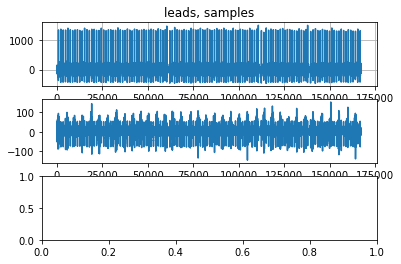

In [32]:

X = np.c_[re_cut_file_data[0], re_cut_file_data[2]]
X_flip_back = X.T
#components = hf.compute_ICA_two_comp(re_cut_file_data)
#x = components
fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
ax_1.grid(True)
ax_1.plot(X_flip_back[0])
ax_1.set(title='leads, samples')
ax_2.plot(X_flip_back[1])


C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


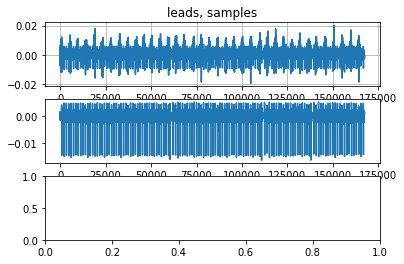

In [33]:

ica = FastICA(n_components=2)
S = ica.fit_transform(X)
S_flip_back = S.T
fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
ax_1.grid(True)
ax_1.plot(S_flip_back[0])
ax_1.set(title='leads, samples')
ax_2.plot(S_flip_back[1])

In [34]:
# dropdown to pick ICA possibilities. CUrrently only one -\o/-
ICA_choice = widgets.Dropdown(
    options=["classic","no_ica_lead3"],
    value='classic',
    description="Select View Option",
    disabled=False,
)
display(ICA_choice)

Dropdown(description='Select View Option', options=('classic', 'no_ica_lead3'), value='classic')

Here we will have to rewrite to accomodate different ICAs, but this is in the future. After we iron out the alternative ICAs. Below we put our EMG data through the pipeline we have now, and we must do picking from an ICA by more peaks or by dis-similarity to the heart/ECG lead.

In [35]:
ICA_picker_choice = widgets.Dropdown(
    options=["more_peaks","similar_to_ECG"],
    value='more_peaks',
    description="Select View Option",
    disabled=False,
)
display(ICA_picker_choice)

Dropdown(description='Select View Option', options=('more_peaks', 'similar_to_ECG'), value='more_peaks')

In [36]:
ICA_picker_choice.value

'more_peaks'

In [37]:
def working_pipeline_pre_entropy_peaks(our_chosen_samples): 
    cut_file_data = hf.bad_end_cutter_for_samples(our_chosen_samples, percent_to_cut=3, tolerance_percent=5)
    bd_filtered_file_data = hf.emg_bandpass_butter_sample(cut_file_data, 5, 450, 2048, output='sos')
    # step 3 end-cutting again to get rid of filtering artifacts
    re_cut_file_data = hf.bad_end_cutter_for_samples(bd_filtered_file_data, percent_to_cut=3, tolerance_percent=5)
    # skip step4 and do step 5 ICA
    components = hf.compute_ICA_two_comp(re_cut_file_data)
    #     the picking step!
    emg= hf.pick_more_peaks_array(components)
    # now process it in final steps
    abs_values = abs(emg)
    final_envelope_d = hf.emg_highpass_butter(abs_values, 150, 2048)
    
        
    return final_envelope_d

def working_pipeline_pre_entropy_ecg(our_chosen_samples): 
    cut_file_data = hf.bad_end_cutter_for_samples(our_chosen_samples, percent_to_cut=3, tolerance_percent=5)
    bd_filtered_file_data = hf.emg_bandpass_butter_sample(cut_file_data, 5, 450, 2048, output='sos')
    # step 3 end-cutting again to get rid of filtering artifacts
    re_cut_file_data = hf.bad_end_cutter_for_samples(bd_filtered_file_data, percent_to_cut=3, tolerance_percent=5)
    # skip step4 and do step 5 ICA
    components = hf.compute_ICA_two_comp(re_cut_file_data)
    #     the picking step!
    emg= hf.pick_lowest_correlation_array(components,re_cut_file_data[0] )
    # now process it in final steps
    abs_values = abs(emg)
    final_envelope_d = hf.emg_highpass_butter(abs_values, 150, 2048)
    
        
    return final_envelope_d

# Let's examine our processed EMG

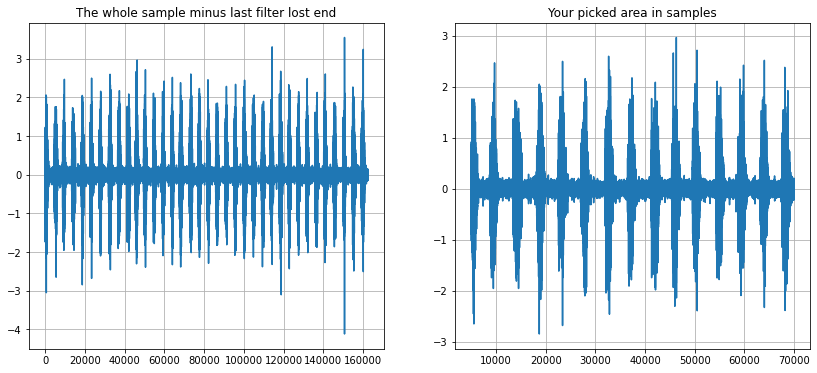

In [38]:
if ICA_picker_choice.value == 'more_peaks':
    processed_data_emg = working_pipeline_pre_entropy_peaks(data_samples)
elif ICA_picker_choice.value == 'similar_to_ECG':
    processed_data_emg = working_pipeline_pre_entropy_ecg(data_samples)
else:
    processed_data_emg = working_pipeline_pre_entropy_ecg(data_samples)

if time_view == 'Seconds':
    %matplotlib inline
    # set up plotn
    x = processed_data_emg
    fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 6))
    axis[0].grid(True)
    axis[0].plot(converted_to_seconds[:len(x)], x)
    axis[0].set(title='The whole sample minus last filter lost end')
    axis[1].set(title='Your picked area in seconds')
    axis[1].grid(True)
    axis[1].plot(converted_to_seconds[int(start*emg_sample_rate):int(end*emg_sample_rate)],x[int(start*emg_sample_rate):int(end*emg_sample_rate)])
else:
    %matplotlib inline
    x = processed_data_emg
    fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 6))
    axis[0].grid(True)
    axis[0].plot(x)
    axis[0].set(title='The whole sample minus last filter lost end')
    axis[1].set(title='Your picked area in samples')
    axis[1].grid(True)
    axis[1].plot(converted_to_samples[int(start):int(end)],x[int(start):int(end)])
    

Now we created some basic processed EMG. We will graph it based on the sample selected and the cutoff on entropy. We will ultimately do a cut-off based on something popular in the literature, but let's do one based on one simple parameter first, as an example


In [39]:
# Now we want to select where the cut_off is

entropy_cutoff = widgets.Dropdown(
    options=["Mean","Half_range"],
    value='Mean',
    description="Select Entropy Cut off",
    disabled=False,
)
display(entropy_cutoff)


Dropdown(description='Select Entropy Cut off', options=('Mean', 'Half_range'), value='Mean')

In [40]:
def rounded_for_ent(stralist):
    rounded= np.round_(stralist, decimals = 5)
    return rounded
start_s= start * emg_sample_rate
end_s = end * emg_sample_rate
if time_view == 'Samples':
    big_list = rounded_for_ent(processed_data_emg[int(start):int(end)])# replace with whole array of time series!
else:
   
    big_list = rounded_for_ent(processed_data_emg[int(start_s):int(end_s)])
slice_length = 100
def sliceIterator(lst, sliceLen):
    for i in range(len(lst) - sliceLen + 1):
        yield lst[i:i + sliceLen]
index_hold = []
for slice in sliceIterator(big_list, slice_length):
    entropy_index = hf.entropical(slice)
    index_hold.append(entropy_index)

if entropy_cutoff.value == 'Half_range':
    decision_cutoff = (np.max(index_hold) + np.min(index_hold))/2
else:# entropy_cutoff.value == 'Mean':
    decision_cutoff = np.mean(index_hold)


rms_rolled = hf.vect_naive_rolling_rms(index_hold,100) # so rms is rms entropy

Now let's see how we would have split it on that criteria

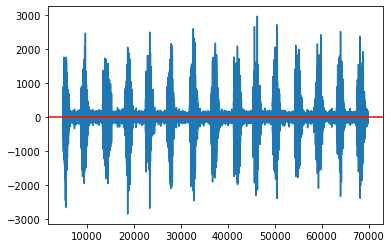

In [41]:
if time_view == 'Samples':
    #y= converted_to_samples
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],processed_data_emg[int(start):(int(start) + len(rms_rolled))]*1000)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],rms_rolled)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    
else:
    y = converted_to_seconds
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))], processed_data_emg[int(start_s):(int(start_s)+len(rms_rolled))]*1000)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))],rms_rolled)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    

In the above picture the green line represents a 0,1, array which represents the breaths. That picking was based on one simple parameter.

# Changes here!
Instead of above code we will do
pick breath based on 90% entropy
then 50%- this will give start of breath
define peak value within 90%
moving forward to right 70%-> with smoothing away if there is too short a pause. This is a more complicated algorithm. 

In [42]:
# reminder
time_view

'Samples'

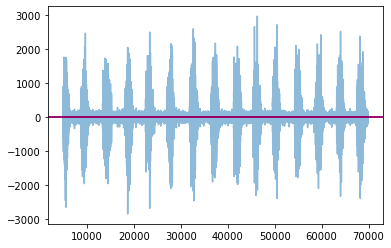

In [43]:

def rounded_for_ent(stralist):
    rounded= np.round_(stralist, decimals = 5)
    return rounded
if time_view == 'Samples':
    big_list = rounded_for_ent(processed_data_emg[int(start):int(end)])# replace with whole array of time series!
else:
    big_list = rounded_for_ent(processed_data_emg[int(start_s):int(end_s)])
slice_length = 100
def sliceIterator(lst, sliceLen):
    for i in range(len(lst) - sliceLen + 1):
        yield lst[i:i + sliceLen]
index_hold = []
for slice in sliceIterator(big_list, slice_length):
    entropy_index = hf.entropical(slice)
    index_hold.append(entropy_index)

high_decision_cutoff = 0.9  * ((np.max(index_hold)) - (np.min(index_hold))) + np.min(index_hold)
decision_cutoff = 0.5 * ((np.max(index_hold)) - (np.min(index_hold))) + np.min(index_hold)

rms_rolled = hf.vect_naive_rolling_rms(index_hold,100) # so rms is rms entropy


if time_view == 'Samples':
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],processed_data_emg[int(start):(int(start) + len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],rms_rolled)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff), color= 'purple')
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    plt.axhline(y = high_decision_cutoff, color = 'purple', linestyle = '-')
    
else:
    y = converted_to_seconds
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))], processed_data_emg[int(start_s):(int(start_s)+len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))],rms_rolled)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))],hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff), color = 'purple')
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    plt.axhline(y = high_decision_cutoff, color = 'purple', linestyle = '-')
    

In [44]:
def merge(left, right):
    # Initialize an empty list output that will be populated with sorted elements.
    # Initialize two variables i and j which are used pointers when iterating through the lists.
    output = []
    i = j = 0

    # Executes the while loop if both pointers i and j are less than the length of the left and right lists
    while i < len(left) and j < len(right):
        # Compare the elements at every position of both lists during each iteration
        if left[i] < right[j]:
            # output is populated with the lesser value
            output.append(left[i])
            # 10. Move pointer to the right
            i += 1
        else:
            output.append(right[j])
            j += 1
    # The remnant elements are picked from the current pointer value to the end of the respective list
    output.extend(left[i:])
    output.extend(right[j:])

    return output

In [45]:


slice = builtins.slice

class Range(namedtuple('RangeBase', 'start,end')):
    
    def intersects(self, other):
        return (
            (self.end >= other.end) and (self.start < other.end) or
            (self.end >= other.start) and (self.start < other.start) or
            (self.end < other.end) and (self.start >= other.start)
        )
    
    def precedes(self, other):
        return self.end < other.start
    
    def to_slice(self):
        return slice(*map(int, self)) # maps whole tuple set
    


def ranges_of(array):
    marks = np.logical_xor(array[1:], array[:-1])
    boundaries = np.hstack((np.zeros(1), np.where(marks != 0)[0], np.zeros(1) + len(array) - 1))

    if not array[0]:
        boundaries = boundaries[1:]
    if len(boundaries) % 2 != 0:
        boundaries = boundaries[:-1]
    return tuple(Range(*boundaries[i:i+2]) for i in range(0, len(boundaries), 2))


def intersections(left, right):
    i, j = 0, 0
    result = []
    while i < len(left) and j < len(right):
        lelt, relt = left[i], right[j]
        if lelt.intersects(relt):
            result.append(lelt)
            i += 1
        elif relt.precedes(lelt):
            j += 1
        elif lelt.precedes(relt):
            i += 1
    return result


hi = np.array(hf.zero_one_for_jumps_base(rms_rolled, high_decision_cutoff))
lo = np.array(hf.zero_one_for_jumps_base(rms_rolled, decision_cutoff))

rhi = ranges_of(hi)
rlo = ranges_of(lo)

keep = intersections(rlo, rhi)


points = np.array(sum(keep, start=()), dtype=np.int32)
points

array([    0, 16620, 16656, 24122, 24171, 26451, 26474, 28610, 28632,
       34542, 34564, 61864, 61869, 64800])

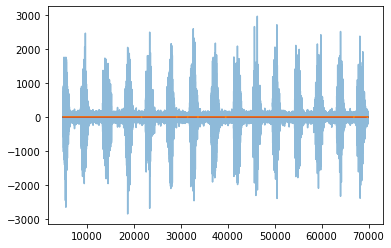

In [46]:
seven_line = np.zeros(len(rms_rolled))
for seven_range in keep:
    seven_line[seven_range.to_slice()] = 7
if time_view == 'Samples':
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],processed_data_emg[int(start):(int(start) + len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff),  color = 'green')
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],(np.array(hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff)))*2, color= 'purple')
    #plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))], six_line)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))], seven_line)
else:
    plt.plot(converted_to_seconds[int(start_s):(int(start_s) + len(rms_rolled))],processed_data_emg[int(start_s):(int(start_s) + len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff),  color = 'green')
    plt.plot(converted_to_seconds[int(start_s):(int(start_s) + len(rms_rolled))],(np.array(hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff)))*2, color= 'purple')
    #plt.plot(converted_tosecondss[int(star_st):(int(star_st) + len(rms_rolled))], six_line)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s) + len(rms_rolled))], seven_line)
    

So above our 'seven-line' represents picking based on finding areas with 90% max entropy, then picking evything around them with over 50% entropy.

## What happened in these breaths?

We want to know the area under the curve for each breath- then the area to where we cross back over 70% of peak values- but should we look at entropy directly- question for Eline. Let's start with breaking the segments into breath or not breath segments.

In [47]:
# our_emg_array = processed_data_emg[int(start):(int(start) + len(rms_rolled))]
# jump_indeces = []
# zippy = zip(seven_line,seven_line[1:])
# for val in enumerate(zippy):
#     if val[1][0] != val[1][1]:
#         print(val[0])
#         jump_indeces.append(val[0])

# grouped = np.split(our_emg_array, jump_indeces)
# grouped

Now we need to figure out which elements of grouped are breath parts, and make arrays of just those.

In [48]:
# so grouped needs to be picked down to where at jump indeces we go up from 0 to 7
our_emg_array_samples = processed_data_emg[int(start):(int(start) + len(rms_rolled))]
our_emg_array_seconds = processed_data_emg[int(start_s):(int(start_s) + len(rms_rolled))]
zippy = zip(seven_line,seven_line[1:])
breath_indeces = []
for val in enumerate(zippy):
    if val[1][0] < val[1][1]:
        print(val[0])
        breath_indeces.append(val[0])
if time_view == 'Samples':
    grouped_breaths = np.split(our_emg_array_samples, breath_indeces)
    grouped_entropy= np.split(rms_rolled, breath_indeces)

else:
    grouped_breaths = np.split(our_emg_array_seconds, breath_indeces)
    grouped_entropy= np.split(rms_rolled, breath_indeces)

16655
24170
26473
28631
34563
61868


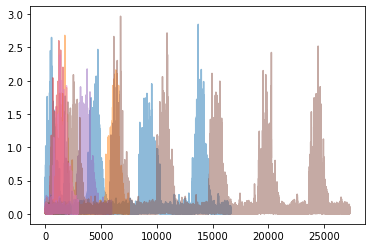

In [49]:
for group in grouped_breaths:
    group = abs(group)
    plt.plot(group, alpha = 0.5)

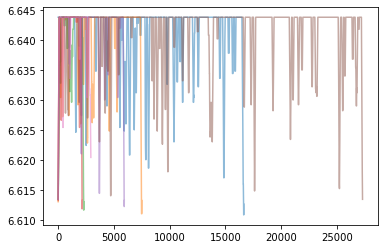

In [50]:
for group in grouped_entropy:
     plt.plot(group, alpha = 0.5)

# now for each breath started segment get the absolute value, smooth it, and get the area under the curve until we reach 70%
The first cell below is an examiner where we plot out the absolute value on each breath group to make sure we are catching breaths.

Now we will plot out the smoothed breaths:

In [ ]:
smoothed_breaths = []
for group in grouped_breaths:
    group = abs(group)
    smoothed = savgol_filter(group, int(0.8* (len(group))), 3)
    plt.plot(smoothed)
    smoothed_breaths.append(smoothed)

Now we will plot out smoothed entropy

In [ ]:
smoothed_breaths_entropy = []
for group in grouped_entropy:
    smoothed = savgol_filter(group, int(0.8* (len(group))), 3)
    plt.plot(smoothed)
    smoothed_breaths_entropy.append(smoothed)

Now we will calculate the area under the curve until the curve of the breath passes it's maximum then hits 70% of it's peak value. 

In [ ]:
curve_area_under = []
for curve in smoothed_breaths:
    max_ind = (curve.argmax())
    max_val = curve[max_ind]
    absolute_val_array = np.abs(curve[max_ind:] - curve.max() * 0.7)
    smallest_difference_index = absolute_val_array.argmin()
    closest_element = curve[max_ind:][smallest_difference_index]
    smallest_difference_index = smallest_difference_index + max_ind
    area_under_curve_cut = curve[:smallest_difference_index].sum()
    curve_area_under.append(area_under_curve_cut)
    

    

In [ ]:
# the future function pending eline approval 
def breath_curve_catch(curve):
    """
    The function is intended for smoothed arrays
    The function takes a smoothed breath array then calculates part of the area under the curve 
    including up to the peak and then to 70% of the peak valye
    """
    max_ind = (curve.argmax())
    max_val = curve[max_ind]
    absolute_val_array = np.abs(curve[max_ind:] - curve.max() * 0.7)
    smallest_difference_index = absolute_val_array.argmin()
    closest_element = curve[max_ind:][smallest_difference_index]
    smallest_difference_index = smallest_difference_index + max_ind
    area_under_curve_cut = curve[:smallest_difference_index].sum()
    return area_under_curve_cut

In [ ]:
# so now we have an array with all of those areas (to 70% of curve ) for each smoothed breath
curve_area_under

OK, but what area these areas? let's see an example of what curve it cuts then takes the area under

In [ ]:
list_of_numbers_to_show = []
for i in range(len(smoothed_breaths)):
    list_of_numbers_to_show.append(str(i))


breath_to_show = widgets.Dropdown(
    options=list_of_numbers_to_show,
    value='1',
    description='Picked Breaths:',
    disabled=False,
)
display(breath_to_show)

In [ ]:
# let's show an example with a graph to show how it looks
curve_example = smoothed_breaths[int(breath_to_show.value)]
max_ind = (curve_example.argmax())
max_val =  curve_example[max_ind]
absolute_val_array = np.abs(curve_example[max_ind:] - curve.max() * 0.7)
smallest_difference_index = absolute_val_array.argmin()
closest_element = curve_example[max_ind:][smallest_difference_index]
smallest_difference_index = smallest_difference_index + max_ind
area_under_curve_cut = curve_example[:smallest_difference_index].sum()
plt.plot(curve_example, color= 'purple', alpha = 0.7)
plt.plot(curve_example[:smallest_difference_index],color = 'green', alpha = 0.9)

## But what if we want to cut on 70% entropy past the peak instead?

In [ ]:
curve_area_under_entropy = []

for i, entropy_curve in enumerate(smoothed_breaths_entropy):
    max_ind = (entropy_curve.argmax())
    max_val = entropy_curve[max_ind]
    absolute_val_array = np.abs(entropy_curve[max_ind:] - entropy_curve.max() * 0.7)
    smallest_difference_index = absolute_val_array.argmin()
    closest_element = entropy_curve[max_ind:][smallest_difference_index]
    smallest_difference_index = smallest_difference_index + max_ind
    area_under_curve_cut = smoothed_breaths[i][:smallest_difference_index].sum()
    curve_area_under_entropy.append(area_under_curve_cut)

In [ ]:
curve_area_under_entropy

In [ ]:
our_emg_array = processed_data_emg[int(start):(int(start) + len(rms_rolled))]
our_entropy_array = rms_rolled
zippy = zip(seven_line,seven_line[1:])
breath_indeces = []
for val in enumerate(zippy):
    if val[1][0] < val[1][1]:
        print(val[0])
        breath_indeces.append(val[0])

grouped_breaths = np.split(our_emg_array, breath_indeces)
grouped_entropy= np.split(rms_rolled, breath_indeces)
grouped_entropy

## So great, we can do it, however we have to agree that the amount of smoothing to calculate these things is acceptable, and whether we use the entropy or the EMG itself

## We also need to agree on what other data is collected into the final spreadsheet

First we can compare counted 'breaths' to algorithm breaths, then we can compare a sequence of peaks.

In [ ]:
my_count = input()

Now let's compare our peak value sequence



Also we are looking at distance from zero to positive maxima, but the amplitude would be from adjancent low value...
We can look at an absolute value array?

In [ ]:
def find_maxima_in_high_entropy_area(our_array,start=0, end=10000, decision_cutoff='mean'):
    """
    Finds maxima in high entropy areas. You need to have made an rms_rolled variable
    on the entropy areas.
    The function is not yet optimized, but works here in the notebook. 
    """
 
    #rms_rolled= 
    decision_array = hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff)
    if decision_array[0] == 1:
        ups_and_downs = np.logical_xor(decision_array[1:], decision_array[:-1])
        indeces_of_boundaries = np.where(ups_and_downs)[0]
        maxima = []
        boundaries = np.append(
            np.append(np.zeros(1), indeces_of_boundaries),
            np.zeros(1) + len(our_array),
        )
        # print(boundaries)
        boundaries = boundaries.astype(np.int32)
        for slice_start, slice_end in zip(boundaries[::2], boundaries[1::2]):
            #print(slice_start, slice_end)
            beat = our_array[slice_start:slice_end]
            maxima.append(slice_start + np.where(beat == beat.max())[0][0])
        maxima_values = our_array[maxima]
        # print(maxima_values)
        rep_array = np.zeros(len(our_array))
        rep_array[maxima] = np.mean(maxima_values)
        plt.plot(our_array, alpha = 0.7)
        plt.plot(rep_array, alpha = 0.4)
    else: 
        ups_and_downs = np.logical_xor(decision_array[1:], decision_array[:-1])
        indeces_of_boundaries = np.where(ups_and_downs)[0]
        maxima = []
        boundaries = np.append(
            indeces_of_boundaries,
            np.zeros(1) + len(our_array),
        )
        boundaries = boundaries.astype(np.int32)
        for slice_start, slice_end in zip(boundaries[::2], boundaries[1::2]):
            #print(slice_start, slice_end)
            beat = our_array[slice_start:slice_end]
            maxima.append(slice_start + np.where(beat == beat.max())[0][0])
        maxima_values = our_array[maxima]
        #print(maxima_values)
        rep_array = np.zeros(len(our_array))
        rep_array[maxima] = np.mean(maxima_values)
        plt.plot(our_array, alpha = 0.7)
        plt.plot(rep_array, alpha = 0.4)
    return maxima, maxima_values
        

In [ ]:
if time_view == 'Samples':
    our_array = processed_data_emg[int(start):int(end)]
    starter=int(start)
    ender= int(end)
else: 
    our_array = processed_data_emg[int(start_s):int(end_s)]
    starter=int(start_s)
    ender= int(end_s)

maximal , maximal_values = find_maxima_in_high_entropy_area(our_array,start=starter, end=ender, decision_cutoff=decision_cutoff)
# note the x axis will be from zero counting up but represent the difference

There are several decisions that need to be made here. Note the following:
    
    We are looking at maxima on the positive. Maybe we should be looking on both sides of zero? Maybe we should be lokking at an absolute value, and then find the maxima? Also note our cut-off on entropy was a bit arbitraty, and gave us an extra breath. These are decisions for the scientific side of a team that need to happen before this interface can go furhter.  

Then we have to decide if we do area under curve for the absolute value, or what?

Now I can save off the info on this run:

In [ ]:
data_now = [file_chosen, number_chosen, time_view, start, end, my_count, maximal, maximal_values, curve_area_under]

In [ ]:
data_now

In [ ]:
big_data_list.append(data_now)
big_data_list

In [ ]:
# data_now = [file_chosen, number_chosen, time_view, start, end, my_count, maximal, maximal_values, curve_area_under]
# columns_now = ['file_chosen',
#                'number_file',
#                'units',
#                'start_cut',
#                'end_cut',
#                'my_hand_count',
#                'automated_breath_count',
#                'maxima',
#                'maxima_values',
#                'curve_area_under',
#                'curve_area_under_entropy',
#                ]

columns_now = ['file_chosen',
               'number_file',
               'units',
               'start_cut',
               'end_cut',
               'my_hand_count',
               #'automated_breath_count',
               'maxima',
               'maxima_values',
               'curve_area_under',
               ]


df = pd.DataFrame(big_data_list, columns=columns_now)

In [ ]:
df

In [ ]:
#You probably want to change the name to a timestamp, and save every hour, at least. 
df.to_csv('my_saved_entropy_experiments.csv')